In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from cemba_data.tools.integration.utilities import calculate_direct_confusion
from ALLCools.plot import *
from ALLCools.plot.color import plot_colorbar
import xarray as xr

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

## Tidy data

In [3]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

## Dot plot

In [5]:
cell_tidy_data = cell_tidy_data[cell_tidy_data['MajorType'] == 'IG-CA2']
cell_tidy_data = cell_tidy_data[cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

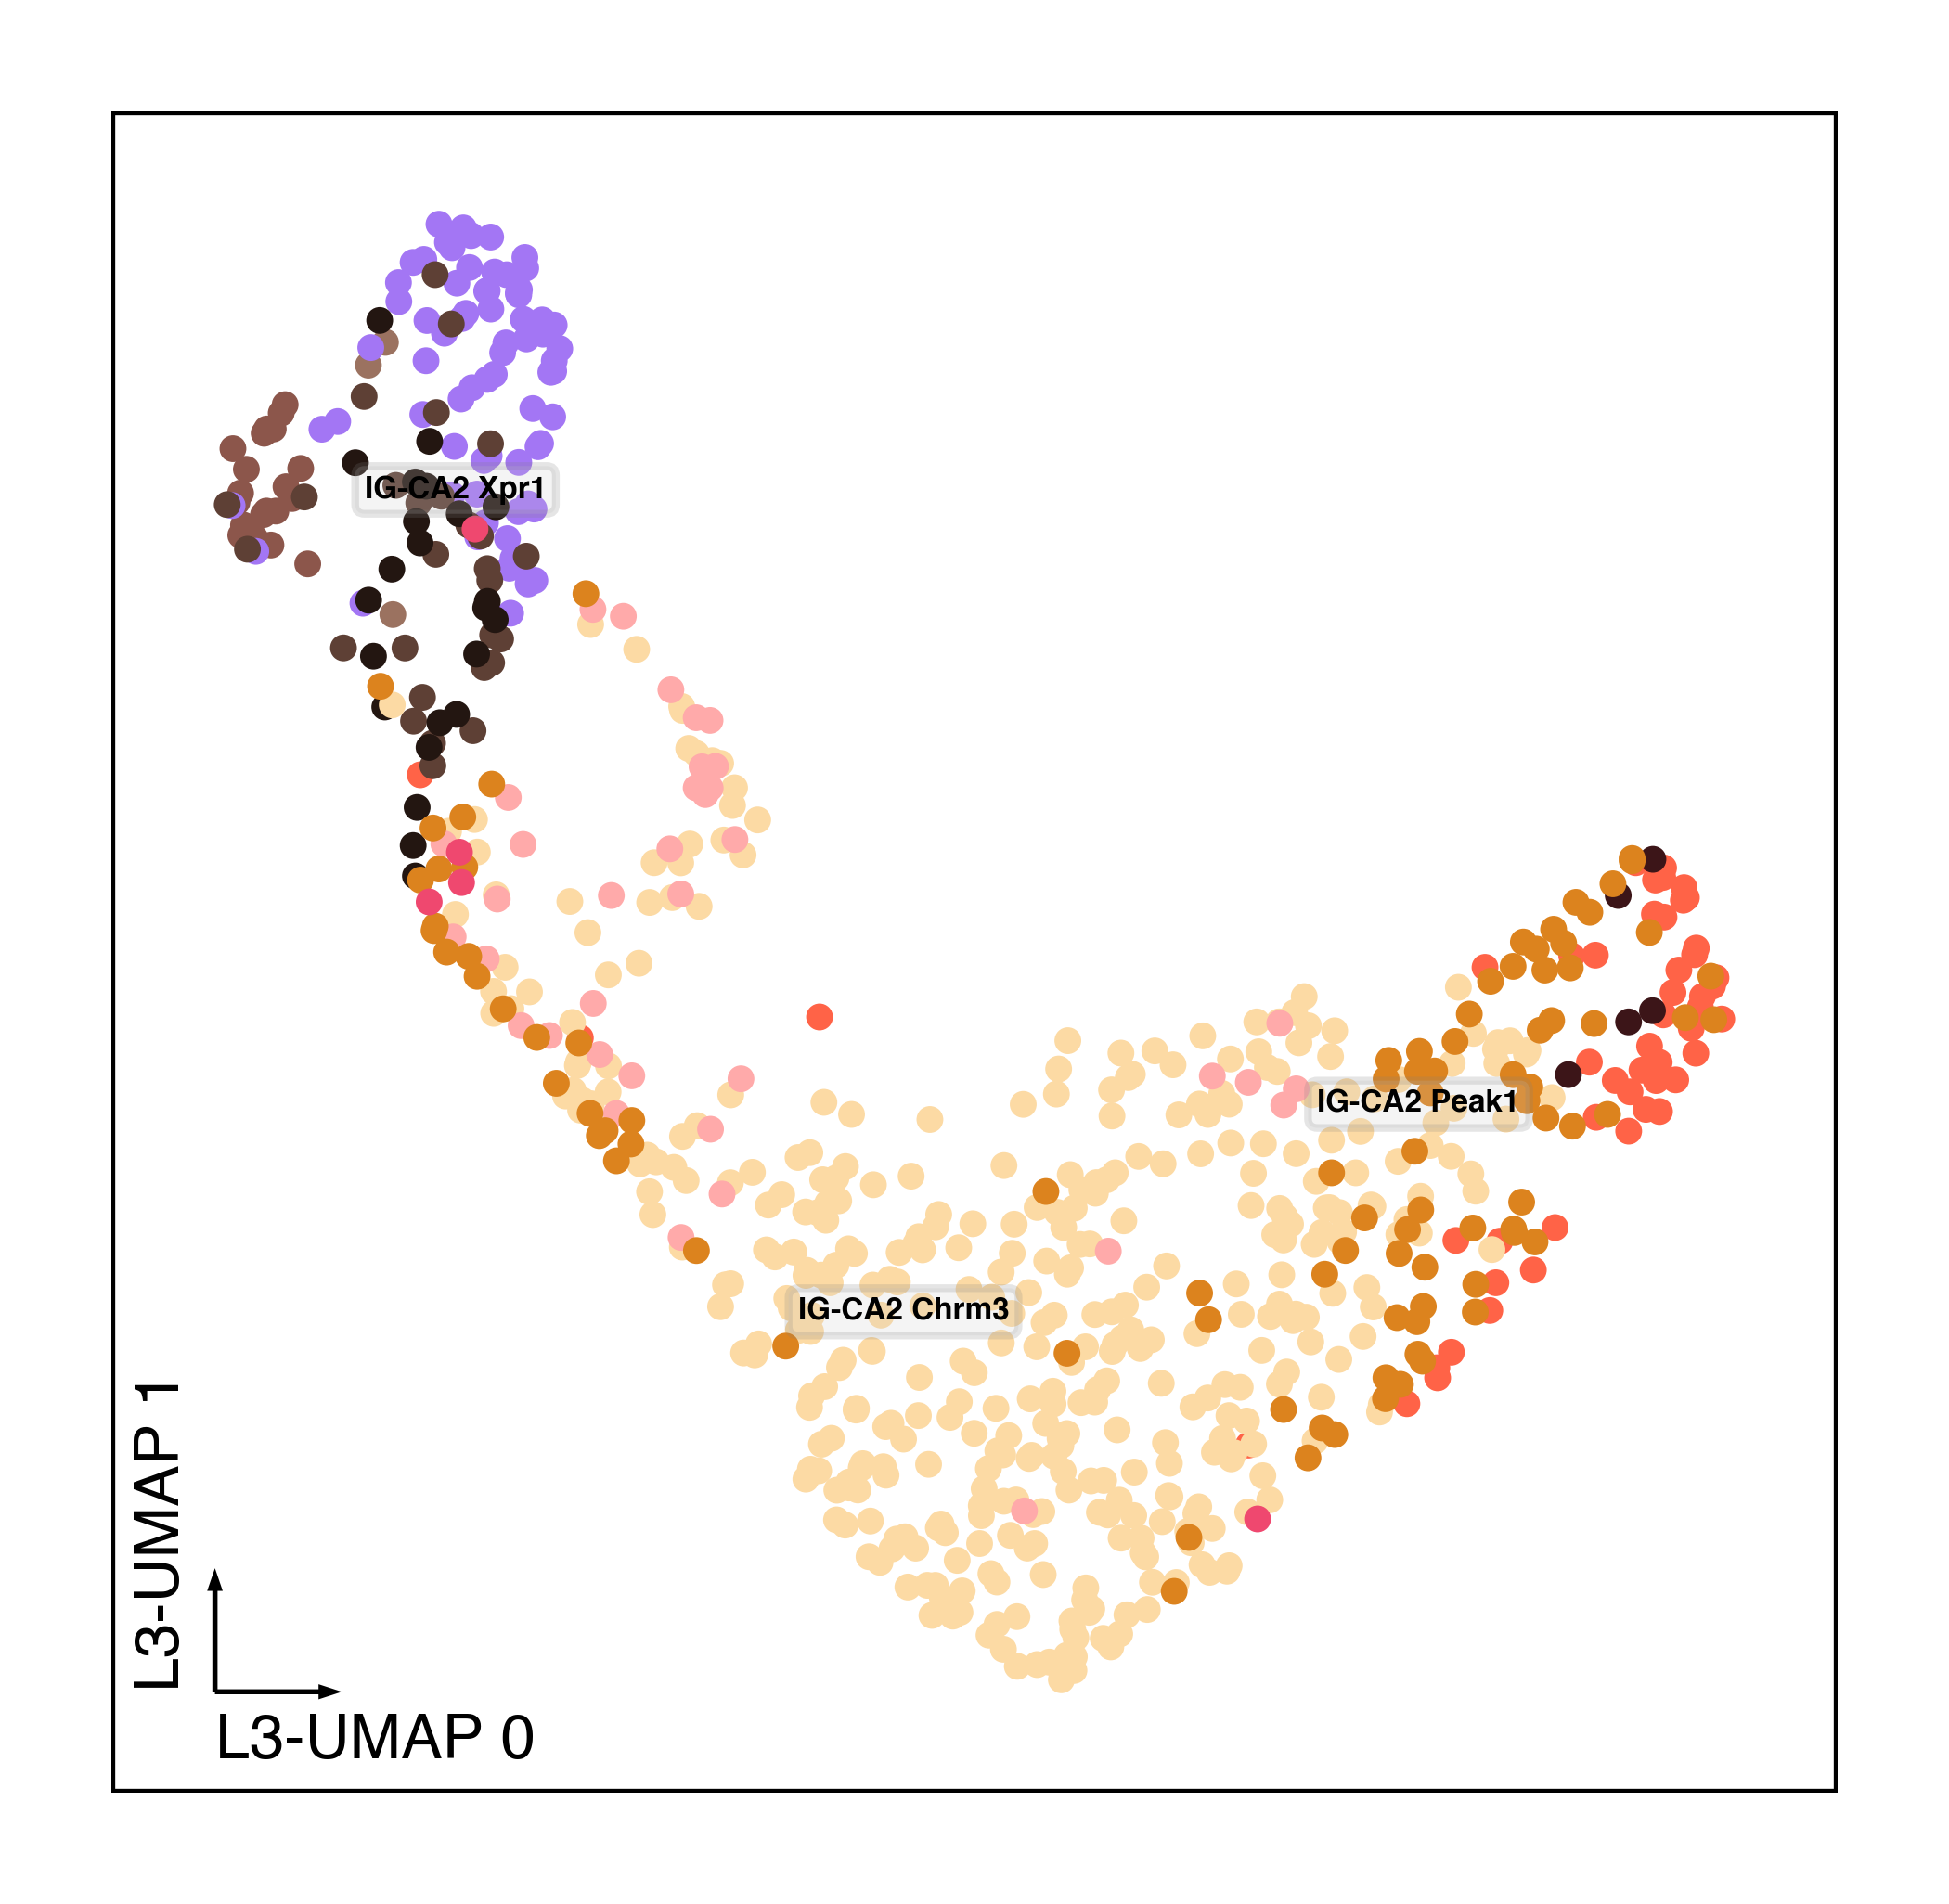

In [7]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='Region',
                    palette=region_palette,
                    s=3,
                    max_points=None,
                    text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

add_ax_box(ax, linewidth=0.5)
pass

In [64]:
cell_tidy_data['SubType'].unique()

array(['IG-CA2 Chrm3', 'IG-CA2 Peak1', 'IG-CA2 Xpr1'], dtype=object)

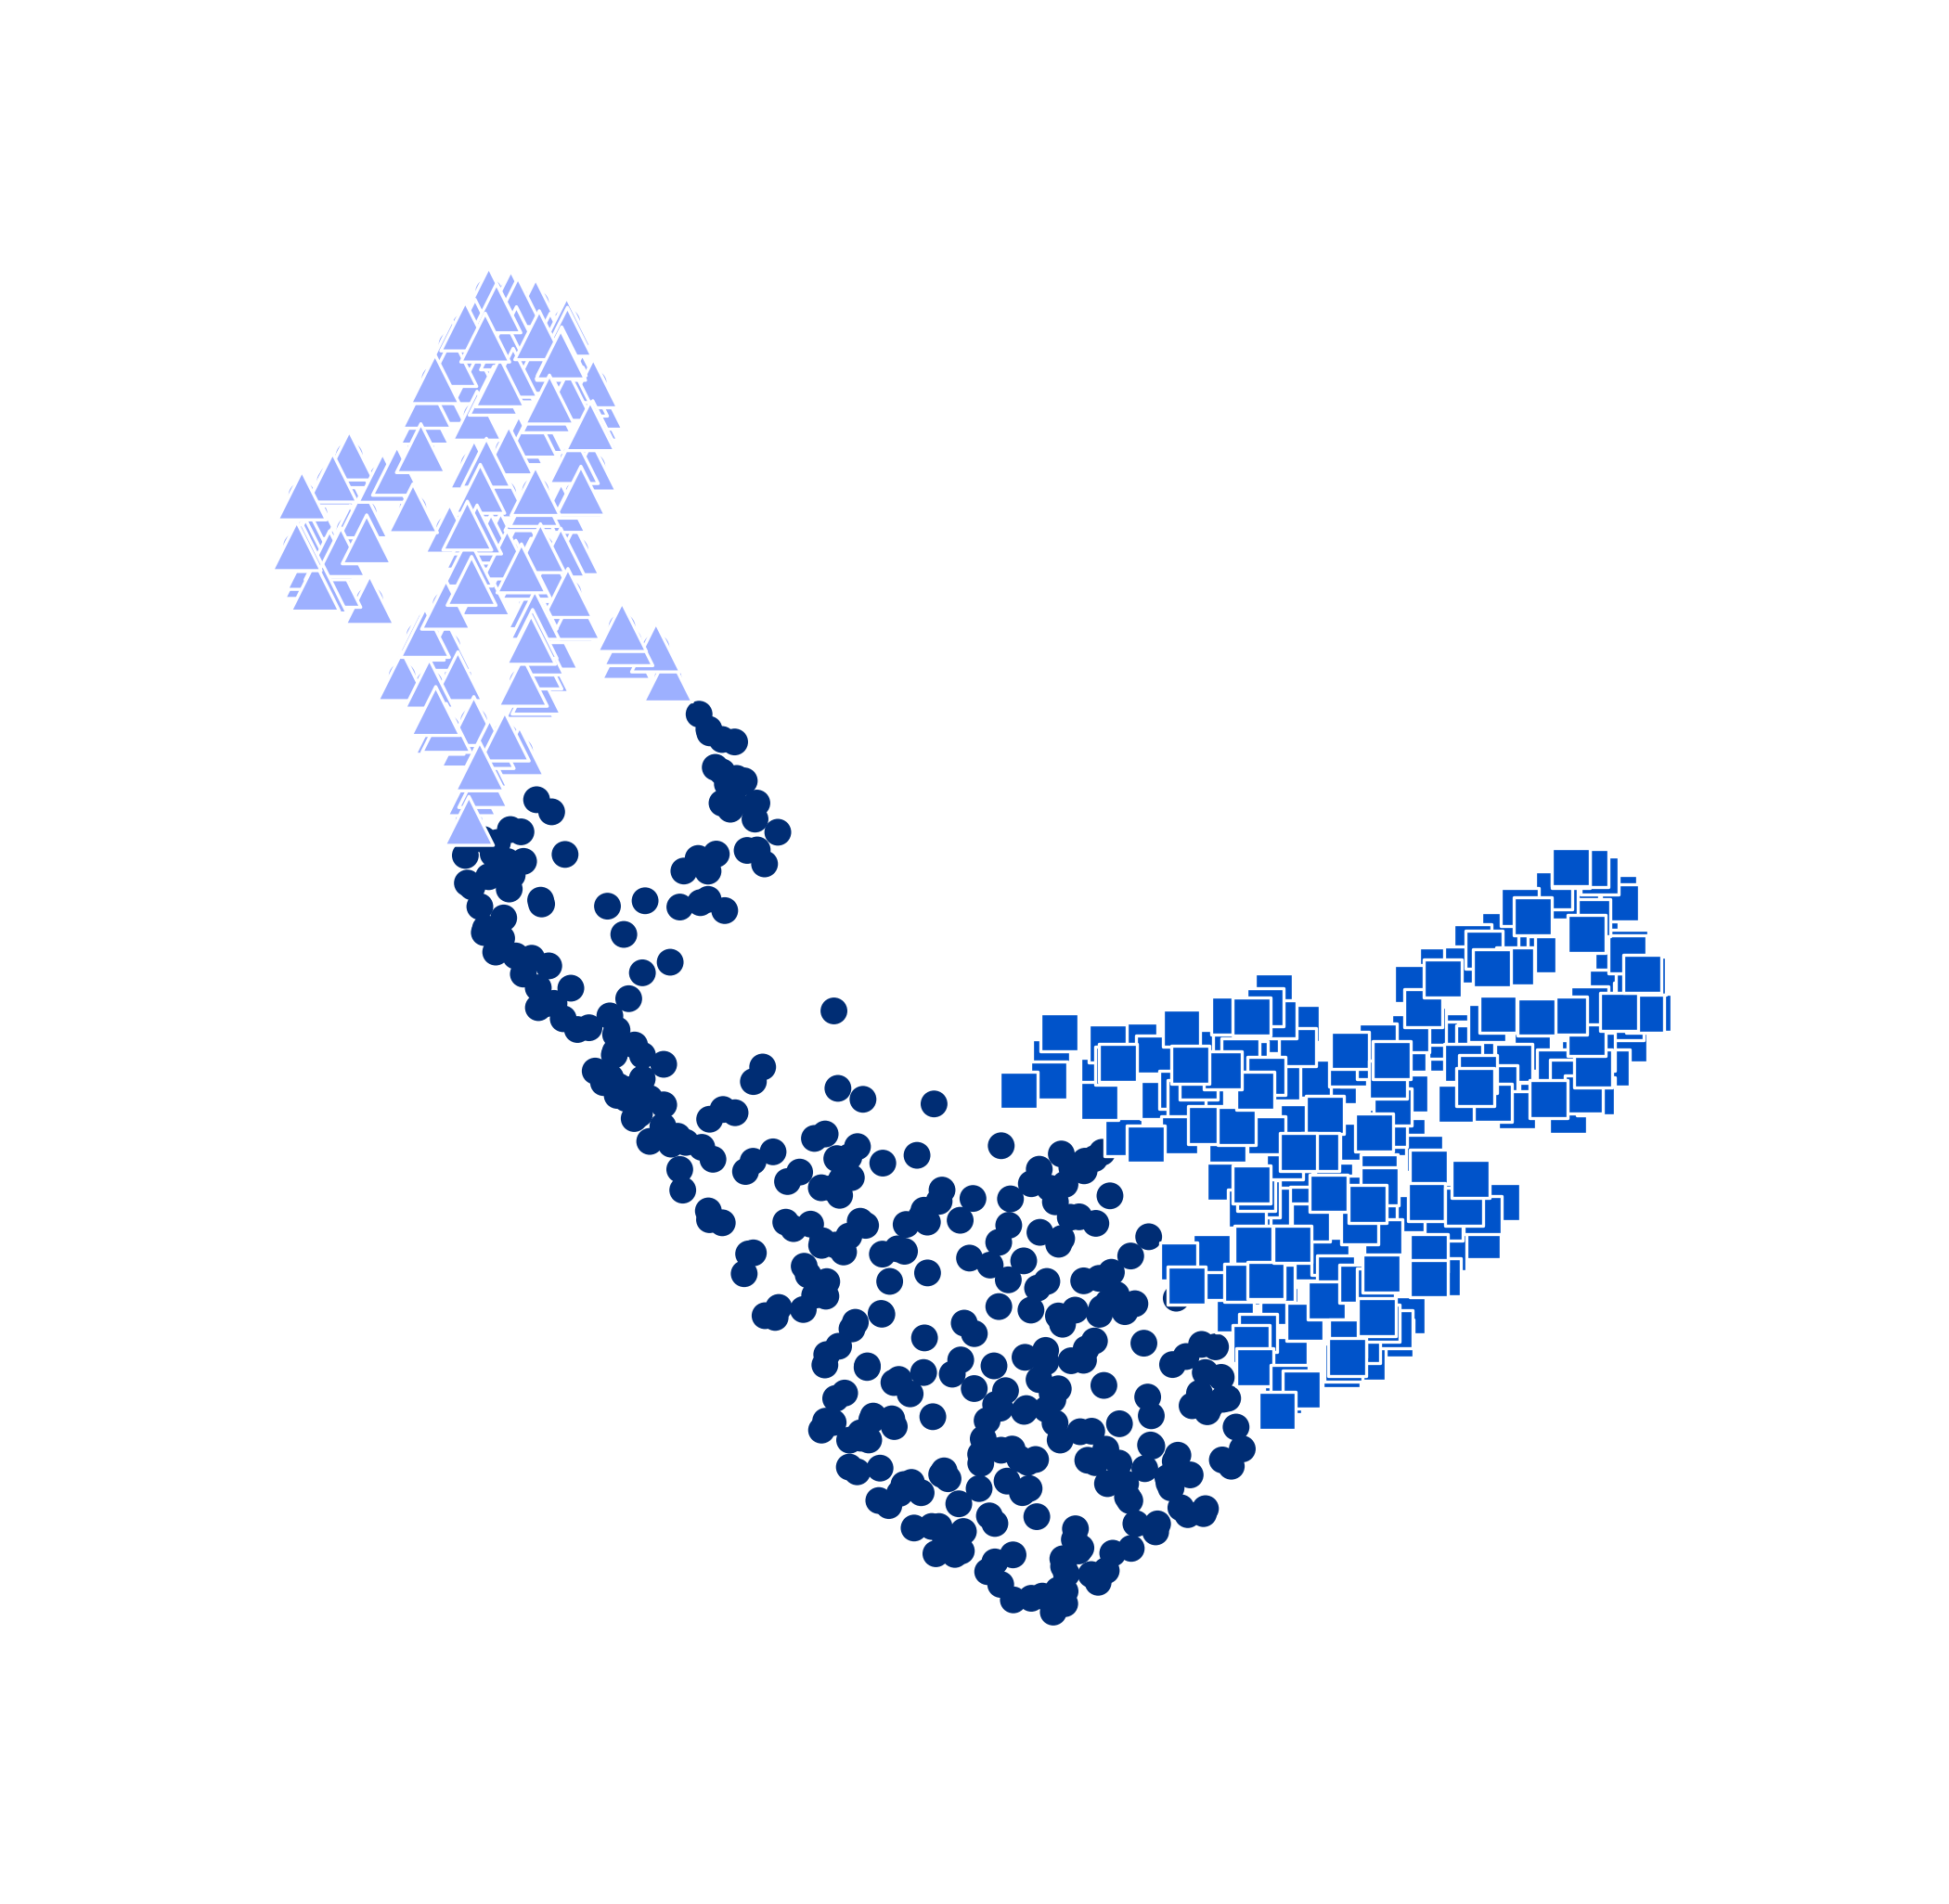

In [70]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='SubType',
                    palette=sub_type_palette,
                    s=3,
                    axis_format=None,
                    max_points=None,
                    #text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

categorical_scatter(ax=ax,
                    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Xpr1'],
                    coord_base='l3-umap',
                    hue='SubType',
                    palette=sub_type_palette,
                    s=10,
                    scatter_kws=dict(linewidth=0.2, marker='^'),
                    axis_format=None,
                    max_points=None,
                    #text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

categorical_scatter(ax=ax,
                    data=cell_tidy_data[cell_tidy_data['SubType'] == 'IG-CA2 Peak1'],
                    coord_base='l3-umap',
                    hue='SubType',
                    palette=sub_type_palette,
                    s=6,
                    scatter_kws=dict(linewidth=0.2, marker='s'),
                    axis_format=None,
                    max_points=None,
                    #text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

#add_ax_box(ax, linewidth=0.5)
fig.savefig('UMAP-IG-CA2.color_by_subtype.scatter_part.png')
pass

In [72]:
ax.get_xlim(), ax.get_ylim()

((-15.887289919371696, 8.332320608611198),
 (-3.2670156478473844, 14.081899356801241))

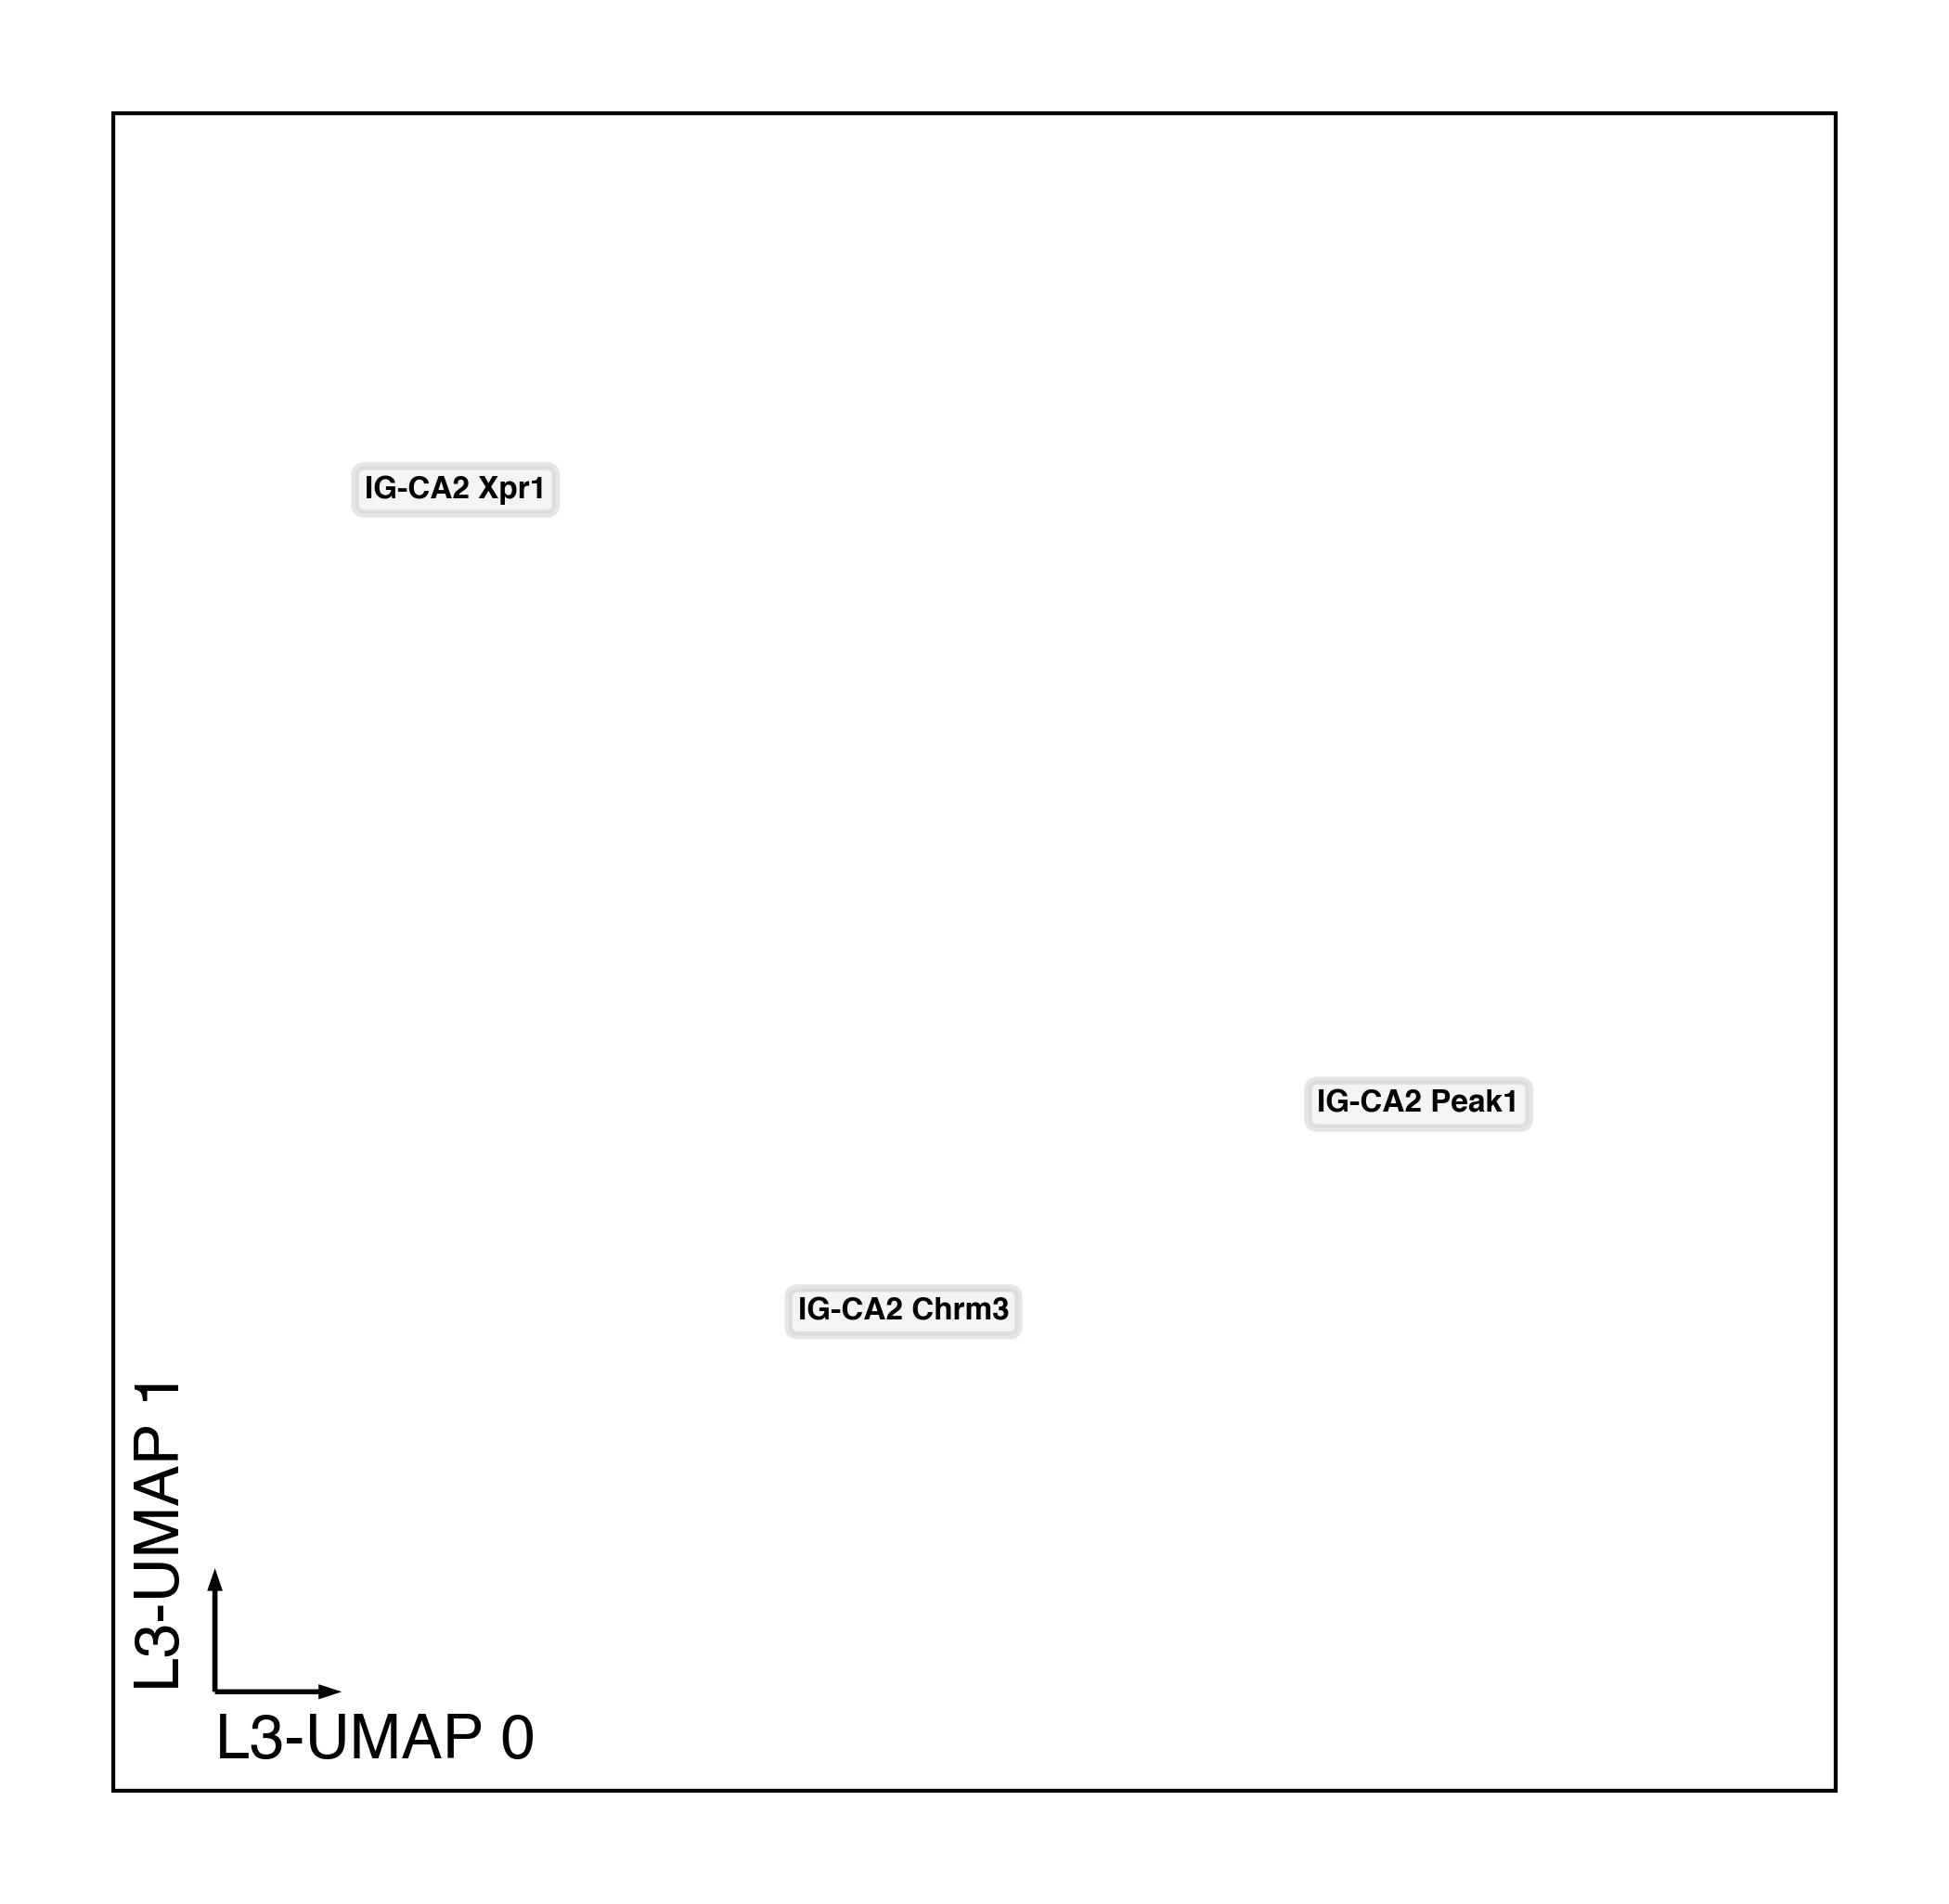

In [14]:
fig, ax = plt.subplots(figsize=(2, 2), dpi=1200)

categorical_scatter(ax=ax,
                    data=cell_tidy_data,
                    coord_base='l3-umap',
                    hue='Region',
                    palette=region_palette,
                    s=3,
                    #axis_format=None,
                    max_points=None,
                    text_anno='SubType', 
                    text_anno_kws=dict(fontsize=2))

add_ax_box(ax, linewidth=0.5)
ax.collections[0].remove()
fig.savefig('UMAP-IG-CA2.color_by_subtype.label_part.pdf')
pass

In [54]:
cluster_order = ['IG-CA2 Xpr1', 'IG-CA2 Chrm3', 'IG-CA2 Peak1']
region_order  = [
    # '3A', '4A', '4G', '5A', '6A', '8E', '8J', '9H', '9J', '10E', '11E'
    'Isocortex', 'CNU', 'HPF'
]

bar_data = cell_tidy_data.groupby('SubType')['MajorRegion'].value_counts().unstack()
bar_data = bar_data.fillna(0).loc[cluster_order, region_order]
bar_data = (bar_data.cumsum(axis=1) / bar_data.sum(axis=1)[:, None]).stack().reset_index()
bar_data.columns = ['SubType', 'Region', 'Ratio']

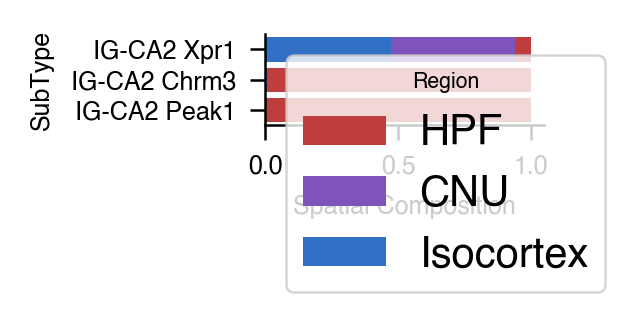

In [74]:
fig, ax = plt.subplots(figsize=(1.2, 0.4), dpi=300)

sns.barplot(ax=ax, data=bar_data, x='Ratio', y='SubType', hue='Region', 
            order=cluster_order, hue_order=region_order[::-1],
            palette=major_region_palette, dodge=False)
ax.set(xlabel='Spatial Composition')
sns.despine(ax=ax)

fig.savefig('IG-CA2_cell_count_by_region.pdf')